# BackBlaze Hard Drive Dataset
---

This project practices Supervised Machine Learning using the [dataset](https://www.backblaze.com/b2/hard-drive-test-data.html) from BackBlaze. The goal is to predict hard drive failure.  

## Table of Contents
---

 - About the Project
 - Getting Started
 - Data Import
 - Data Exploration
     - Hard-drive Models
     - Nulls
     - Outliers
     - Univariate Exploration
     - Multivariate Exploration
     - Bivariate Analysis
 - Feature Engineering
 - Dimensionality Reduction
     - PCA
 - Running Models
 - Next Steps

## About the Project
---

In this project we explore a dataset of hard-drives at a cloud-server company called BackBlaze.  The dataset contains daily maintenance information of roughly 105,000 hard-drives including a labeled instances of failure.

## Data Import
---

The files for a quarter-year in question were roughly 0.5GB compressed, I wanted to minimize the amount of space data occupied, so keeping them compressed/zipped was ideal.

The files are hosted on BackBlazes own servers, so I created a function that downloads the zip files if they weren't found on my local hard drive, extracts the files of interest (the daily .csv records) then concat them together into one big dataframe so we can explore them.

In [1]:
import os
import io
from zipfile import ZipFile
import requests
import urllib

import pandas as pd
import numpy as np

In [2]:
# Variables to Change
YEAR = 2018 # 2013+
QUARTER = 1 # 1, 2, 3, 4

DOWNLOAD_ROOT = 'https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/'
HDD_PATH = os.path.join('datasets', 'drive_stats', str(YEAR))
HDD_URL = DOWNLOAD_ROOT + f'data_Q{QUARTER}_{YEAR}.zip'

def yield_zipped_files(zip_path):
    with ZipFile(zip_path) as hdd_zip:
        for zip_info in hdd_zip.infolist():
            with hdd_zip.open(zip_info) as thefile:
                if zip_info.filename.endswith('.csv') and not '_MACOSX' in zip_info.filename:
                    yield thefile

def download_extract_zip_in_memory(url=HDD_URL):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    Useful if I don't want to save anything on HDD
    and don't mind downloading the same file every time
    """
    response = requests.get(url)
    return yield_zipped_files(io.BytesIO(response.content))

def download_extract_zip(hdd_url=HDD_URL, hdd_path=HDD_PATH, year=YEAR, quarter=QUARTER):
    """
    Pretty much does the above but downloads the zip first
    Before extracting contents in memory
    Doesn't download if it's downloaded already.
    Useful if I don't want to download all the time.
    """
    os.makedirs(hdd_path, exist_ok=True)
    filename = 'data_Q{}_{}.zip'.format(str(quarter), str(year))
    zip_path = os.path.join(hdd_path, filename)
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(hdd_url, zip_path)
    return yield_zipped_files(zip_path)

def just_download_zip(hdd_url=HDD_URL, hdd_path=HDD_PATH, year=YEAR, quarter=QUARTER):
    """
    Only downloads the file
    Doesn't extract contents to memory
    """
    os.makedirs(hdd_path, exist_ok=True)
    filename = 'data_Q{}_{}.zip'.format(str(quarter), str(year))
    zip_path = os.path.join(hdd_path, filename)
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(hdd_url, zip_path)

def import_data_full():
    """
    Downloads file, extracts contents to memory,
    then creates dataframe of content
    """
    df = pd.concat(pd.read_csv(f) for f in download_extract_zip())
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    return df

In [3]:
df_raw = import_data_full()

## Data Exploration
---

Since 2013, BackBlaze has published statistics and insights based on the hard drives in their data center. The data consists of daily snapshots of each operational hard drive. This snapshot includes basic drive information along with the [S.M.A.R.T](https://en.wikipedia.org/wiki/S.M.A.R.T.) statistics reported by that drive. The daily snapshot of one drive is one row of data. All of the drive snapshots for a given day are collected into a csv file in the format YYYY-MM-DD.csv (e.g. 2013-04-10.csv) consisting of a row for each active hard drive.

The first row of each file contains the column names:
 - Date
 - Serial Number : Manufacturer assigned serial number of the drive
 - Model : Manufacturer model of the drive
 - Capacity : Drive capacity in bytes
 - Failure : Binary label with 1 indicating that this was the last day the drive was operational before failing.
 - SMART stats
    - 2013-2014 : Raw and Normalized values for 40 different SMART stats.
    - 2015-2017 : Raw and Normalized values for 45 different SMART stats.
    - 2018 (Q1) : Raw and Normalized values for 50 different SMART stats.
    - 2018 (Q2) : Raw and Normalized values for 52 different SMART stats.
    - 2018 (Q4) : Raw and Normalized values for 62 different SMART stats.

In [4]:
df_raw.shape

(8949492, 105)

In [5]:
df_raw.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2018-02-04,Z305B2QN,ST4000DM000,4000787030016,0,118.0,179547432.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-02-04,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,102.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-02-04,ZA16NQJR,ST8000NM0055,8001563222016,0,78.0,67614504.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-02-04,ZA18CEBT,ST8000NM0055,8001563222016,0,100.0,1580176.0,NaN,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-02-04,ZA18CEBS,ST8000NM0055,8001563222016,0,82.0,161864784.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_raw.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
count,8.949492e+06,8.949492e+06,8.948907e+06,8.948907e+06,2.235026e+06,2.235026e+06,8.948907e+06,8.948907e+06,8.948907e+06,8.948907e+06,...,808.0,8.080000e+02,808.000000,808.000000,808.0,808.0,7859.00000,7859.0,0.0,0.0
mean,6.226809e+12,3.754403e-05,9.823156e+01,9.058507e+07,1.357605e+02,9.568266e+01,9.865506e+01,1.681774e+02,9.999839e+01,9.341276e+00,...,1.0,2.211055e+07,8.228960,142006.452970,100.0,0.0,117.92849,0.0,NaN,NaN
std,3.027689e+12,6.127204e-03,1.892843e+01,8.102416e+07,2.074655e+01,2.582596e+01,1.243579e+01,7.532267e+02,7.484056e-02,8.816474e+01,...,0.0,1.809970e+07,25.772685,102712.953773,0.0,0.0,38.36151,0.0,NaN,NaN
min,-1.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,9.200000e+01,0.000000e+00,8.300000e+01,0.000000e+00,9.200000e+01,1.000000e+00,...,1.0,3.653400e+04,1.000000,189.000000,100.0,0.0,100.00000,0.0,NaN,NaN
25%,4.000787e+12,0.000000e+00,8.200000e+01,0.000000e+00,1.330000e+02,1.000000e+02,9.300000e+01,0.000000e+00,1.000000e+02,2.000000e+00,...,1.0,5.963820e+06,1.000000,43123.250000,100.0,0.0,100.00000,0.0,NaN,NaN
50%,4.000787e+12,0.000000e+00,1.000000e+02,7.936073e+07,1.340000e+02,1.020000e+02,9.700000e+01,0.000000e+00,1.000000e+02,5.000000e+00,...,1.0,1.527972e+07,1.000000,115834.500000,100.0,0.0,100.00000,0.0,NaN,NaN
75%,8.001563e+12,0.000000e+00,1.140000e+02,1.630967e+08,1.340000e+02,1.040000e+02,1.000000e+02,0.000000e+00,1.000000e+02,9.000000e+00,...,1.0,3.437693e+07,1.000000,244457.500000,100.0,0.0,100.00000,0.0,NaN,NaN
max,1.200014e+13,1.000000e+00,2.000000e+02,5.934976e+08,2.520000e+02,7.170000e+02,2.530000e+02,1.117900e+04,1.000000e+02,8.553000e+03,...,1.0,5.845669e+07,100.000000,306135.000000,100.0,0.0,200.00000,0.0,NaN,NaN


For each SMART variable, there is a `normalized` and `raw` column.  Normalized does not mean the mathematical normalization, but instead is manufacturer-defined, so it differs by hard-drive models.

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8949492 entries, 0 to 100349
Columns: 105 entries, date to smart_255_raw
dtypes: datetime64[ns](1), float64(100), int64(2), object(2)
memory usage: 7.1+ GB


Also, all the SMART values should be `ints` not `floats`.  Found out they are `floats` because those columns contain nulls.  Will change them to `ints` once nulls get fixed.

In [8]:
num_drives = df_raw.serial_number.nunique()
num_days = df_raw.date.nunique()
print('The dataset is {} hard-drives reporting their \
SMART data daily for {} days.'.format(num_drives, num_days))

The dataset is 105004 hard-drives reporting their SMART data daily for 90 days.


In [9]:
fails = df_raw['failure'].sum()
print('Number of drive failures: {}'.format(fails))
print('Percentage of hard-drives that fail: {:.2f}%'.format((fails / num_drives)*100))

Number of drive failures: 336
Percentage of hard-drives that fail: 0.32%


From domain knowledge, we know there are no rigerous standardizations for how hard-drives read and record SMART data, so we need to filter by hard-drive model.

Let's see what model is most prevelant.

### Hard-Drive Models

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

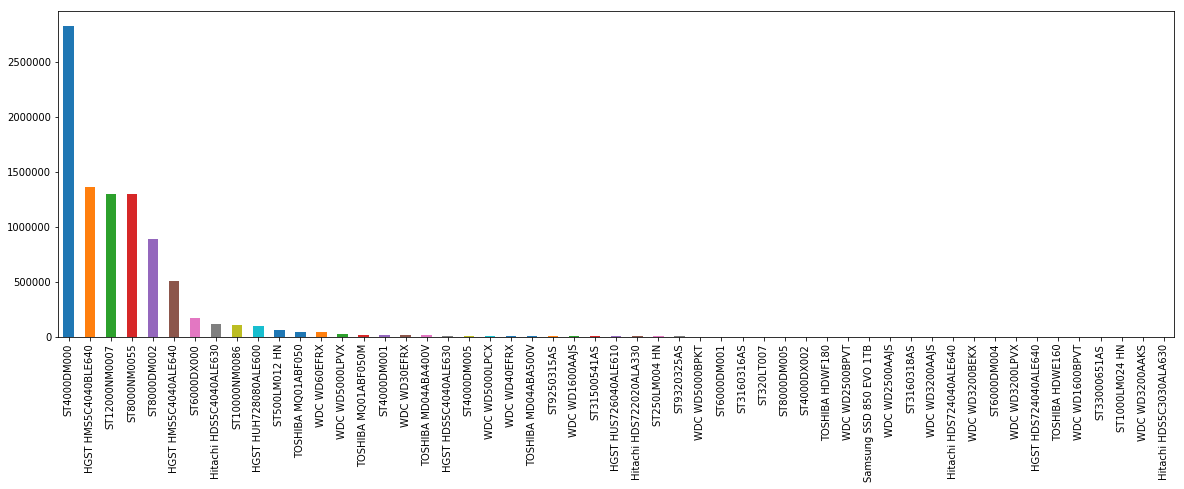

In [11]:
df_raw['model'].value_counts().plot(kind='bar', figsize=(20,6))

The most common model is `ST4000DM000`.

In [12]:
df_hd = df_raw[df_raw['model'] == 'ST4000DM000']

In [13]:
df_hd.shape

(2822282, 105)

In [14]:
num_drives = df_hd.serial_number.nunique()
print('The dataset is {} hard-drives.'.format(num_drives))
fails = df_hd['failure'].sum()
print('Number of drive failures: {}'.format(fails))
print('Percentage of hard-drives that fail: {:.2f}%'.format((fails / num_drives)*100))

The dataset is 32091 hard-drives.
Number of drive failures: 178
Percentage of hard-drives that fail: 0.55%


### Nulls

In [15]:
def nulls_breakdown(df):
    df_cols = list(df.columns)
    cols_total_count = len(df_cols)
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(
                loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('')
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(
        cols_total_count, cols_count, cols_percent_null))

In [16]:
nulls_breakdown(df_hd)

[iloc = 5] smart_1_normalized has 12 null values: 0.0% null
[iloc = 6] smart_1_raw has 12 null values: 0.0% null
[iloc = 7] smart_2_normalized has 2822282 null values: 100.0% null
[iloc = 8] smart_2_raw has 2822282 null values: 100.0% null
[iloc = 9] smart_3_normalized has 12 null values: 0.0% null
[iloc = 10] smart_3_raw has 12 null values: 0.0% null
[iloc = 11] smart_4_normalized has 12 null values: 0.0% null
[iloc = 12] smart_4_raw has 12 null values: 0.0% null
[iloc = 13] smart_5_normalized has 12 null values: 0.0% null
[iloc = 14] smart_5_raw has 12 null values: 0.0% null
[iloc = 15] smart_7_normalized has 12 null values: 0.0% null
[iloc = 16] smart_7_raw has 12 null values: 0.0% null
[iloc = 17] smart_8_normalized has 2822282 null values: 100.0% null
[iloc = 18] smart_8_raw has 2822282 null values: 100.0% null
[iloc = 19] smart_9_normalized has 12 null values: 0.0% null
[iloc = 20] smart_9_raw has 12 null values: 0.0% null
[iloc = 21] smart_10_normalized has 12 null values: 0.0% 

Some columns are almost entirely null.  Not all hard-drives will report every SMART value, so it's not uncommon. Columns with over 30% null is not worth salvaging, so they should be dropped.

Dropping those columns with over 30% null so graphing every column won't look like a CVS reciept

In [17]:
# df_dnc => DataFrame_DroppedNullColumns 
df_dnc = df_hd.loc[:, df_hd.isnull().sum() < 0.25*df_hd.shape[0]]

In [18]:
df_dnc.shape

(2822282, 53)

In [19]:
nulls_breakdown(df_dnc)

[iloc = 5] smart_1_normalized has 12 null values: 0.0% null
[iloc = 6] smart_1_raw has 12 null values: 0.0% null
[iloc = 7] smart_3_normalized has 12 null values: 0.0% null
[iloc = 8] smart_3_raw has 12 null values: 0.0% null
[iloc = 9] smart_4_normalized has 12 null values: 0.0% null
[iloc = 10] smart_4_raw has 12 null values: 0.0% null
[iloc = 11] smart_5_normalized has 12 null values: 0.0% null
[iloc = 12] smart_5_raw has 12 null values: 0.0% null
[iloc = 13] smart_7_normalized has 12 null values: 0.0% null
[iloc = 14] smart_7_raw has 12 null values: 0.0% null
[iloc = 15] smart_9_normalized has 12 null values: 0.0% null
[iloc = 16] smart_9_raw has 12 null values: 0.0% null
[iloc = 17] smart_10_normalized has 12 null values: 0.0% null
[iloc = 18] smart_10_raw has 12 null values: 0.0% null
[iloc = 19] smart_12_normalized has 12 null values: 0.0% null
[iloc = 20] smart_12_raw has 12 null values: 0.0% null
[iloc = 21] smart_183_normalized has 12 null values: 0.0% null
[iloc = 22] smart_

In [20]:
df_dnc.fillna(method='ffill', inplace=True)

C:\Users\Kenei\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [21]:
nulls_breakdown(df_dnc)


Out of 53 total columns, 0 contain null values; 0.0% columns contain null values.


Now that the nulls are taken care of, I can change floats to int (the nulls were why they are floats to begin with)

In [22]:
def df_dtypes_fix(df):
    columns = df.columns.tolist()
    for col in columns:
        if 'model' in col or 'serial_number' in col:
            df[col] = df[col].astype('object')
        elif 'date' in col:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
        else:
            df[col] = df[col].astype('int64')
    return df

In [23]:
df_ints = df_dtypes_fix(df_dnc)

C:\Users\Kenei\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Kenei\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Kenei\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [24]:
df_ints.shape

(2822282, 53)

In [25]:
df_ints.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2018-02-04,Z305B2QN,ST4000DM000,4000787030016,0,118,179547432,91,0,100,...,100,0,200,0,100,18517,100,39861309504,100,61223935581
5,2018-02-04,Z305DEMG,ST4000DM000,4000787030016,0,114,77562744,97,0,100,...,100,0,200,0,100,16724,100,33761503720,100,67591424864
10,2018-02-04,Z3023VGH,ST4000DM000,4000787030016,0,112,45302624,92,0,100,...,100,0,200,0,100,28769,100,23172730201,100,171042731260
13,2018-02-04,Z305DEMX,ST4000DM000,4000787030016,0,112,48269528,93,0,100,...,100,0,200,0,100,18507,100,40319606344,100,60960743336
19,2018-02-04,Z306WYZZ,ST4000DM000,4000787030016,0,114,73815424,95,0,100,...,100,0,200,0,100,4050,100,12566112872,100,33641419848


### Outliers

In [26]:
def outliers_visual(data):
    plt.figure(figsize=(15, 80))
    i = 0
    cols = list(data.columns)[5:]
    for col in cols:
        i += 1
        plt.subplot(26, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(26, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()

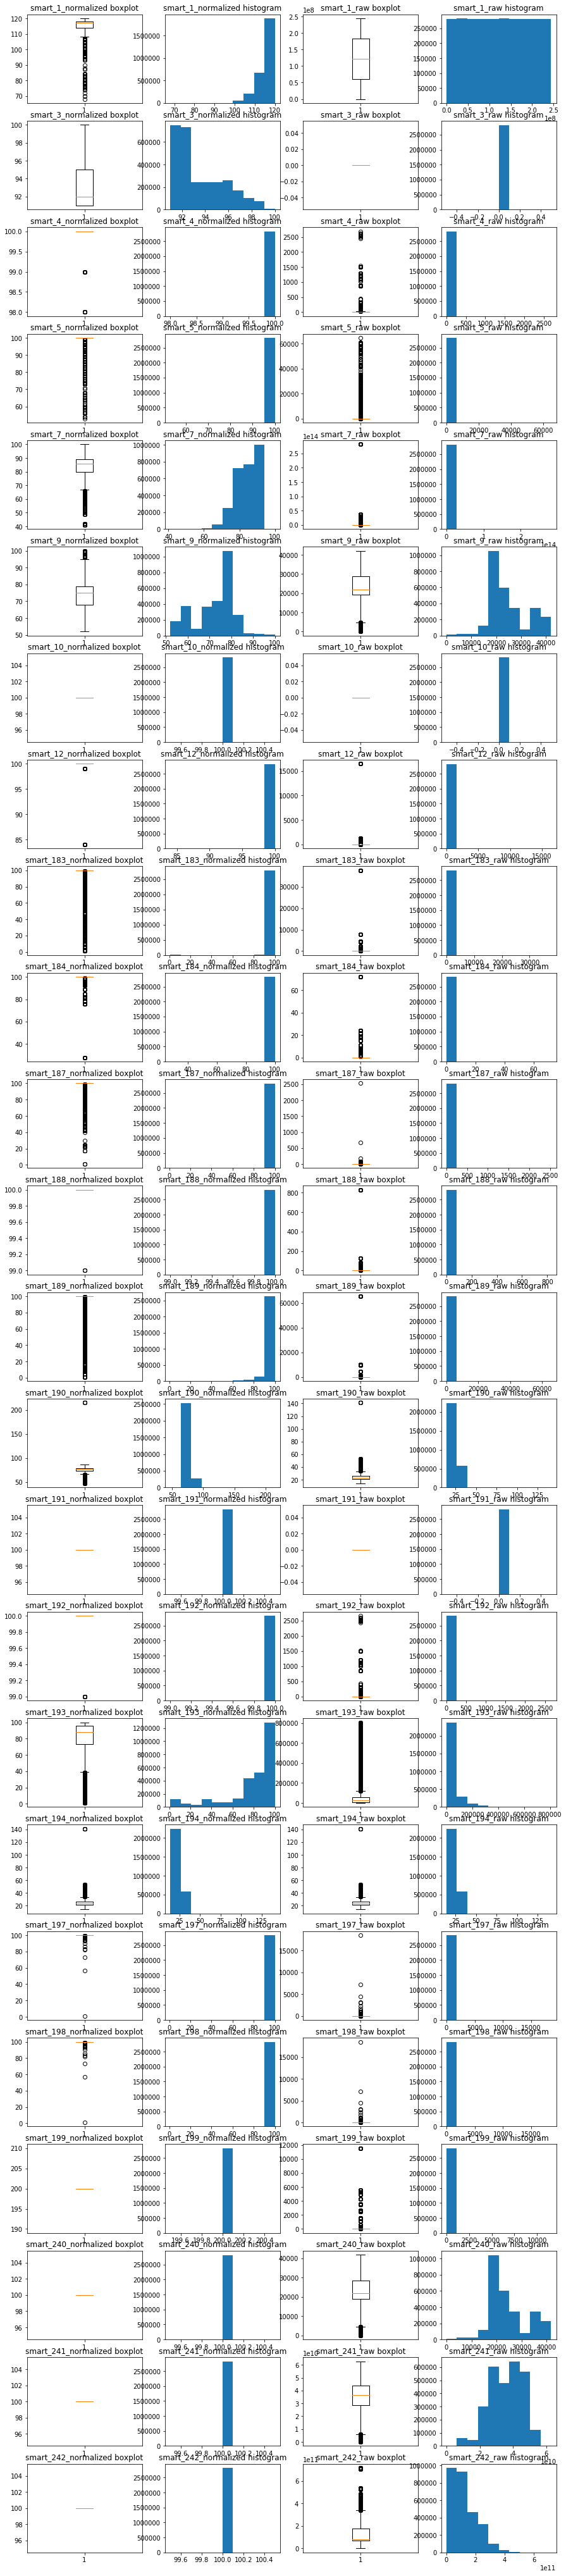

In [27]:
outliers_visual(df_ints) # Boxplots may be empty if dataset is too large

Considering the nature of the dataset, we should not winsorize outliers as we are interested in said outliers. We are interested in anomoly data (hard-drives failing) so we won't be removing the outliers.  When we run models though, we will standardize columns if needed.

### Univariate Exploration

In [28]:
df_ints.describe(include=['O'])

,serial_number,model
count,2822282,2822282
unique,32091,1
top,Z305GVP3,ST4000DM000
freq,90,2822282


In [29]:
def show_max_columns(df):
    pd.set_option('display.max_columns', df.shape[1])
    display(df)
    pd.reset_option('display.max_columns')

In [30]:
show_max_columns(df_ints.describe()) # now with less columns than df_raw

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_189_normalized,smart_189_raw,smart_190_normalized,smart_190_raw,smart_191_normalized,smart_191_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
count,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2822282.0,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2822282.0,2822282.0,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2822282.0,2822282.0,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2.822282e+06,2822282.0,2.822282e+06,2822282.0,2.822282e+06,2822282.0,2.822282e+06,2822282.0,2.822282e+06
mean,4.000770e+12,6.306953e-05,1.152958e+02,1.220490e+08,9.334248e+01,0.0,9.999986e+01,1.039989e+01,9.999590e+01,5.279917e+00,8.407224e+01,1.117871e+10,7.245438e+01,2.456850e+04,100.0,0.0,9.999946e+01,1.050118e+01,9.931271e+01,3.205109e+00,9.997745e+01,2.254523e-02,9.988017e+01,1.209209e-01,1.000000e+02,1.292284e-01,9.795537e+01,4.716345e+00,7.616174e+01,2.383871e+01,100.0,0.0,9.999999e+01,1.662920e+00,7.854611e+01,4.796866e+04,2.383871e+01,2.383871e+01,9.999982e+01,1.979419e-01,9.999982e+01,1.979419e-01,200.0,2.215281e+00,100.0,2.430062e+04,100.0,3.595514e+10,100.0,1.229511e+11
std,8.249640e+09,7.941384e-03,3.874761e+00,7.049239e+07,2.327837e+00,0.0,1.262635e-02,1.958270e+01,2.665750e-01,3.479783e+02,5.824973e+00,1.601448e+12,8.737237e+00,7.649115e+03,0.0,0.0,9.052737e-02,9.368896e+01,5.555480e+00,2.228620e+02,6.811281e-01,6.811281e-01,1.392361e+00,2.087836e+00,1.031004e-03,4.824487e+00,6.106989e+00,3.753345e+02,3.909503e+00,3.908246e+00,0.0,0.0,2.791962e-03,1.789901e+01,2.510527e+01,6.885094e+04,3.908246e+00,3.908246e+00,6.989802e-02,1.304171e+01,6.989802e-02,1.304171e+01,0.0,9.814337e+01,0.0,7.578378e+03,0.0,9.678483e+09,0.0,8.135185e+10
min,-1.000000e+00,0.000000e+00,6.800000e+01,0.000000e+00,9.100000e+01,0.0,9.800000e+01,1.000000e+00,5.300000e+01,0.000000e+00,4.100000e+01,1.210000e+02,5.200000e+01,6.000000e+00,100.0,0.0,8.400000e+01,0.000000e+00,1.000000e+00,0.000000e+00,2.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,9.900000e+01,0.000000e+00,1.000000e+00,0.000000e+00,4.700000e+01,1.400000e+01,100.0,0.0,9.900000e+01,0.000000e+00,1.000000e+00,3.000000e+00,1.400000e+01,1.400000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,200.0,0.000000e+00,100.0,5.000000e+00,100.0,6.441464e+06,100.0,1.081700e+04
25%,4.000787e+12,0.000000e+00,1.140000e+02,6.100917e+07,9.100000e+01,0.0,1.000000e+02,5.000000e+00,1.000000e+02,0.000000e+00,8.000000e+01,1.126805e+08,6.800000e+01,1.910600e+04,100.0,0.0,1.000000e+02,5.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,7.400000e+01,2.100000e+01,100.0,0.0,1.000000e+02,0.000000e+00,7.300000e+01,8.954000e+03,2.100000e+01,2.100000e+01,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,200.0,0.000000e+00,100.0,1.886100e+04,100.0,2.869708e+10,100.0,6.803376e+10
50%,4.000787e+12,0.000000e+00,1.170000e+02,1.220513e+08,9.200000e+01,0.0,1.000000e+02,8.000000e+00,1.000000e+02,0.000000e+00,8.600000e+01,5.084103e+08,7.500000e+01,2.201700e+04,100.0,0.0,1.000000e+02,8.000

For histograms of each SMART columns, please check outliers section above.

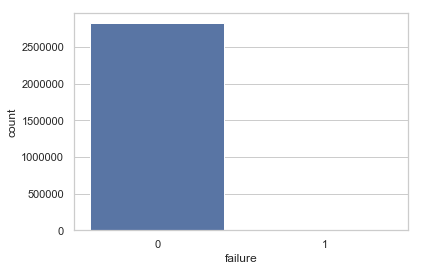

In [31]:
import seaborn as sns
sns.set(style="whitegrid")

sns.countplot(x='failure', data=df_ints)  

Too small to even see.

### Multivariate Exploration

#### Correlation Matrix

In [32]:
hd_corr = df_ints.corr()

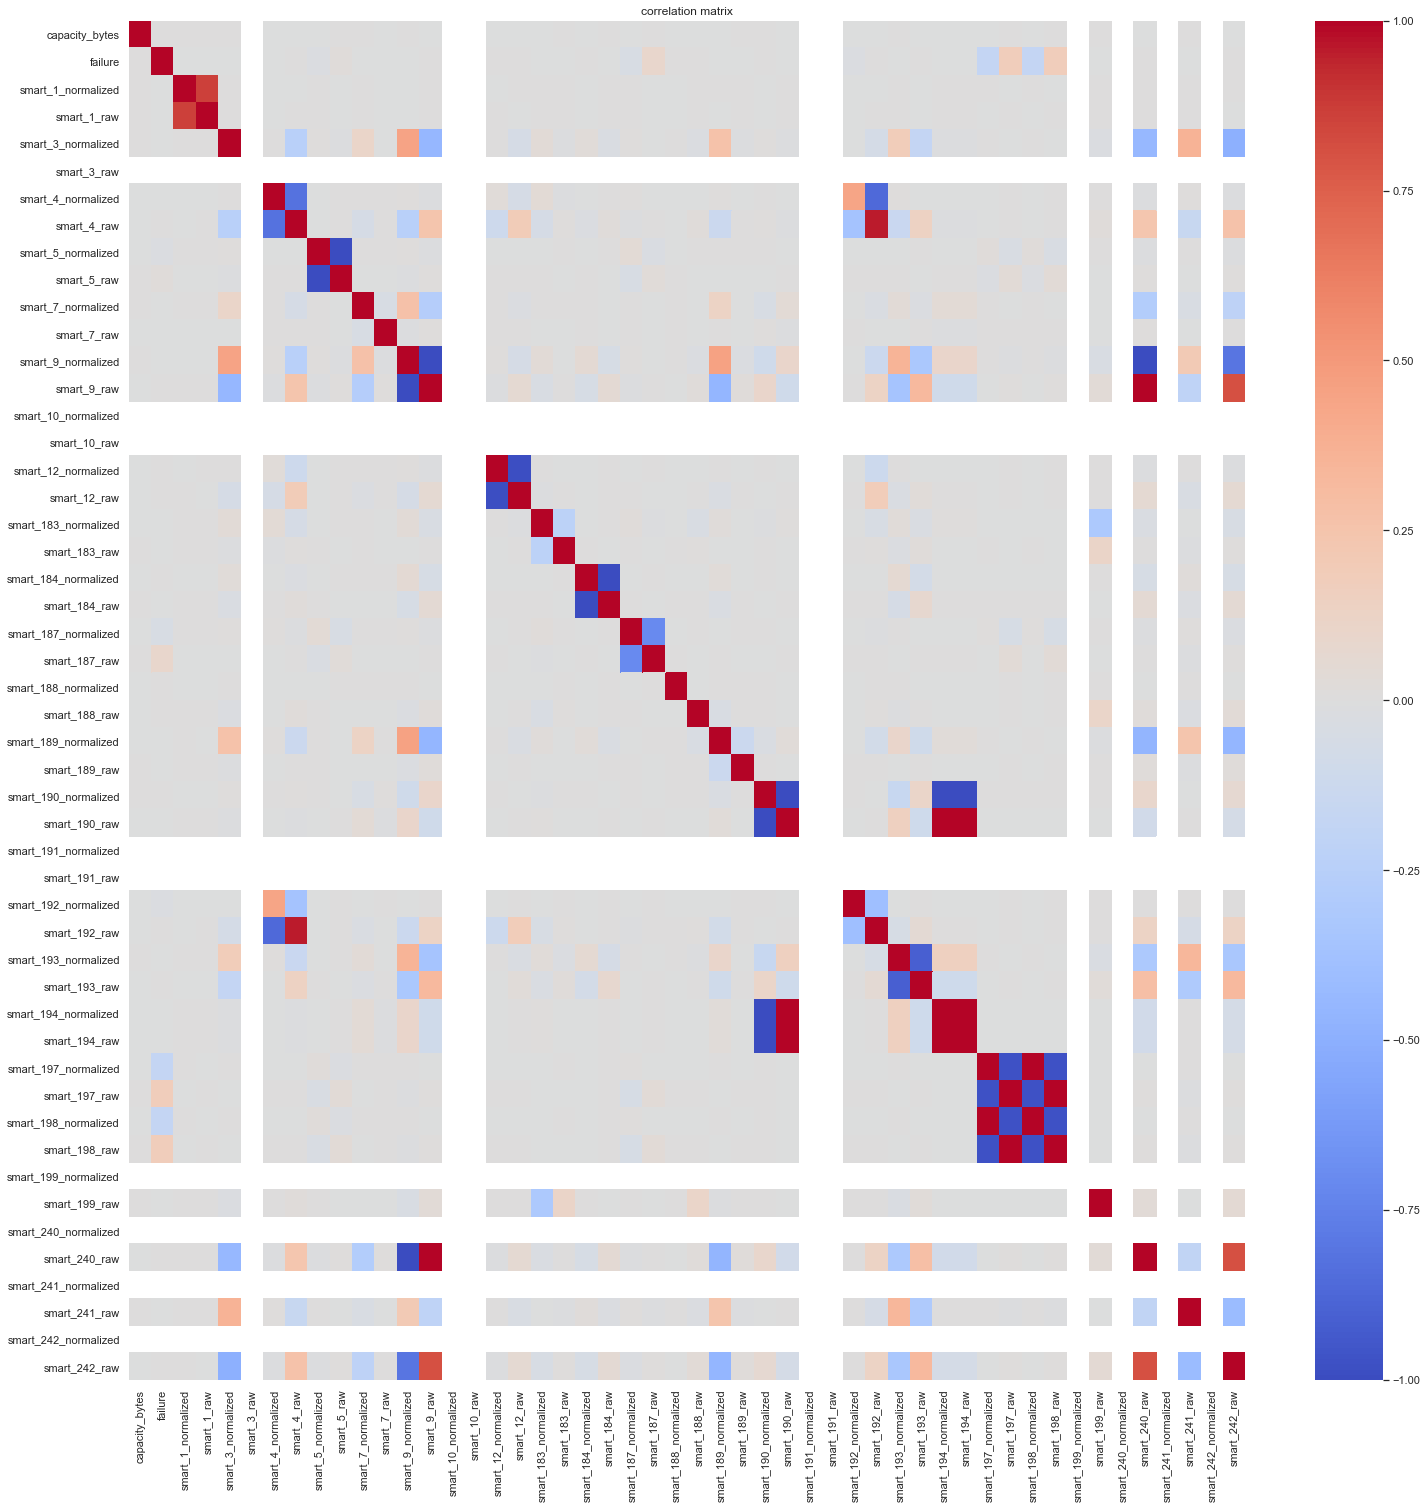

In [33]:
plt.figure(figsize=(25,25))

sns.heatmap(hd_corr, cmap= 'coolwarm')
plt.title("correlation matrix")

plt.show()

Kinda too big, can't really tell what's going on.  Let's split based on `raw` and `normalized` columns.

In [34]:
# Split raw and normalized
def remove_raw(data):
    cols = data.columns.tolist()
    cols_raw = list(filter(lambda col: '_raw' in col, cols))
    return data.drop(columns=cols_raw)

def remove_norm(data):
    cols = data.columns.tolist()
    cols_norm = list(filter(lambda col: '_normalized' in col, cols))
    return data.drop(columns=cols_norm)

In [35]:
df_raw = remove_norm(df_ints)
df_norm = remove_raw(df_ints)

##### RAW

We see RAW columns of SMART 3, 10, and 191 are stagnant, so let's drop them.

In [36]:
print(df_raw.shape)
df_raw = df_raw.drop(columns=(['smart_3_raw', 'smart_10_raw', 'smart_191_raw']))
print(df_raw.shape)

(2822282, 29)
(2822282, 26)


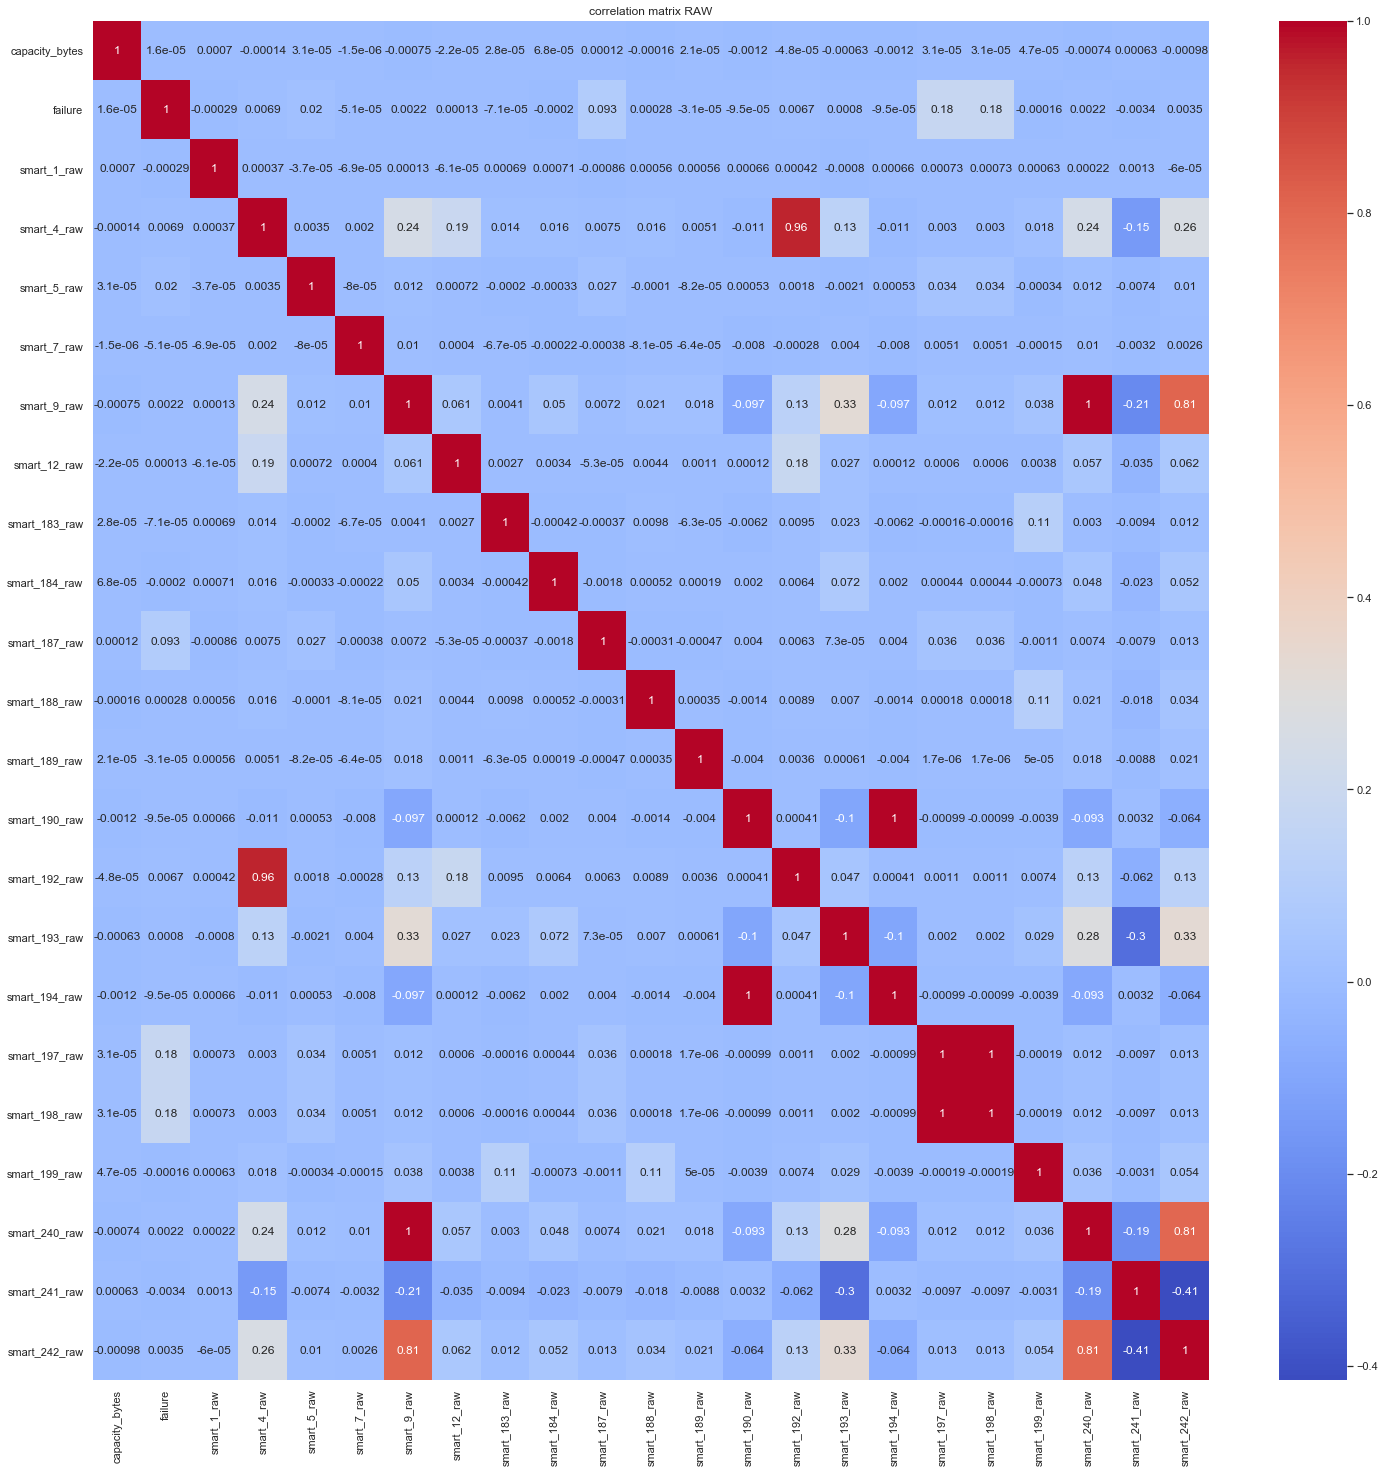

In [37]:
# RAWS
hd_corr_raw = df_raw.corr()

plt.figure(figsize=(25,25))

# draw the heatmap using seaborn.
sns.heatmap(hd_corr_raw, annot=True, cmap= 'coolwarm')
plt.title("correlation matrix RAW")

plt.show()

A few observations:
- `smart_9_raw` (Power-on Hours) and `smart_240_raw` (Head-Flying Hours) has correlation of 1.00.  Makes sense as at a cloud-center as soon as a drive is turned on, it's put to work so the head will constantly be flying.
- `smart_190_raw` (Temperature Difference) and `smart_194_raw` (Temperature) has correlation of 1.00.  Makes sense they're related.
- `smart_197_raw` (Current Pending Sector Count) and `smart_198_raw` (Uncorrectable Sector Count) has correlation of 1.0.  Makes sense they're related, as one continues to add up, while the other is current amount and can go down.
- `smart_4_raw` (Start/Stop Count) and `smart_192_raw` (Power-off Retract Count) has correlation of 0.96.  Both these numbers should be very similar.

I'm going to drop the latter of each of the pairs to minimize the number of factors.

In [38]:
# def drop_high_corr_features(df, threshold=0.9):
#     threshold = threshold
#     df_corr = df.corr()
#     columns = np.full((df_corr.shape[0],), True, dtype=bool)
#     for i in range(df_corr.shape[0]):
#         for j in range(i+1, df_corr.shape[0]):
#             if df_corr.iloc[i,j] >= threshold:
#                 if columns[j]:
#                     columns[j] = False
#     selected_columns = df.columns[columns]
#     return df[selected_columns]
to_drop_raw = ['smart_240_raw', 'smart_194_raw', 'smart_192_raw', 'smart_198_raw']
df_raw.drop(columns=to_drop_raw, axis=1, inplace=True)
df_ints.drop(columns=to_drop_raw, axis=1, inplace=True)

C:\Users\Kenei\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


##### NORMALIZED

We see normalized columns of SMART 10, 191, 199, 240, 241, 242 are stagnant, so let's drop them.

In [39]:
print(df_norm.shape)
df_norm = df_norm.drop(columns=(['smart_10_normalized',
                                'smart_191_normalized',
                                'smart_199_normalized',
                                'smart_240_normalized',
                                'smart_241_normalized',
                                'smart_242_normalized']))
print(df_norm.shape)

(2822282, 29)
(2822282, 23)


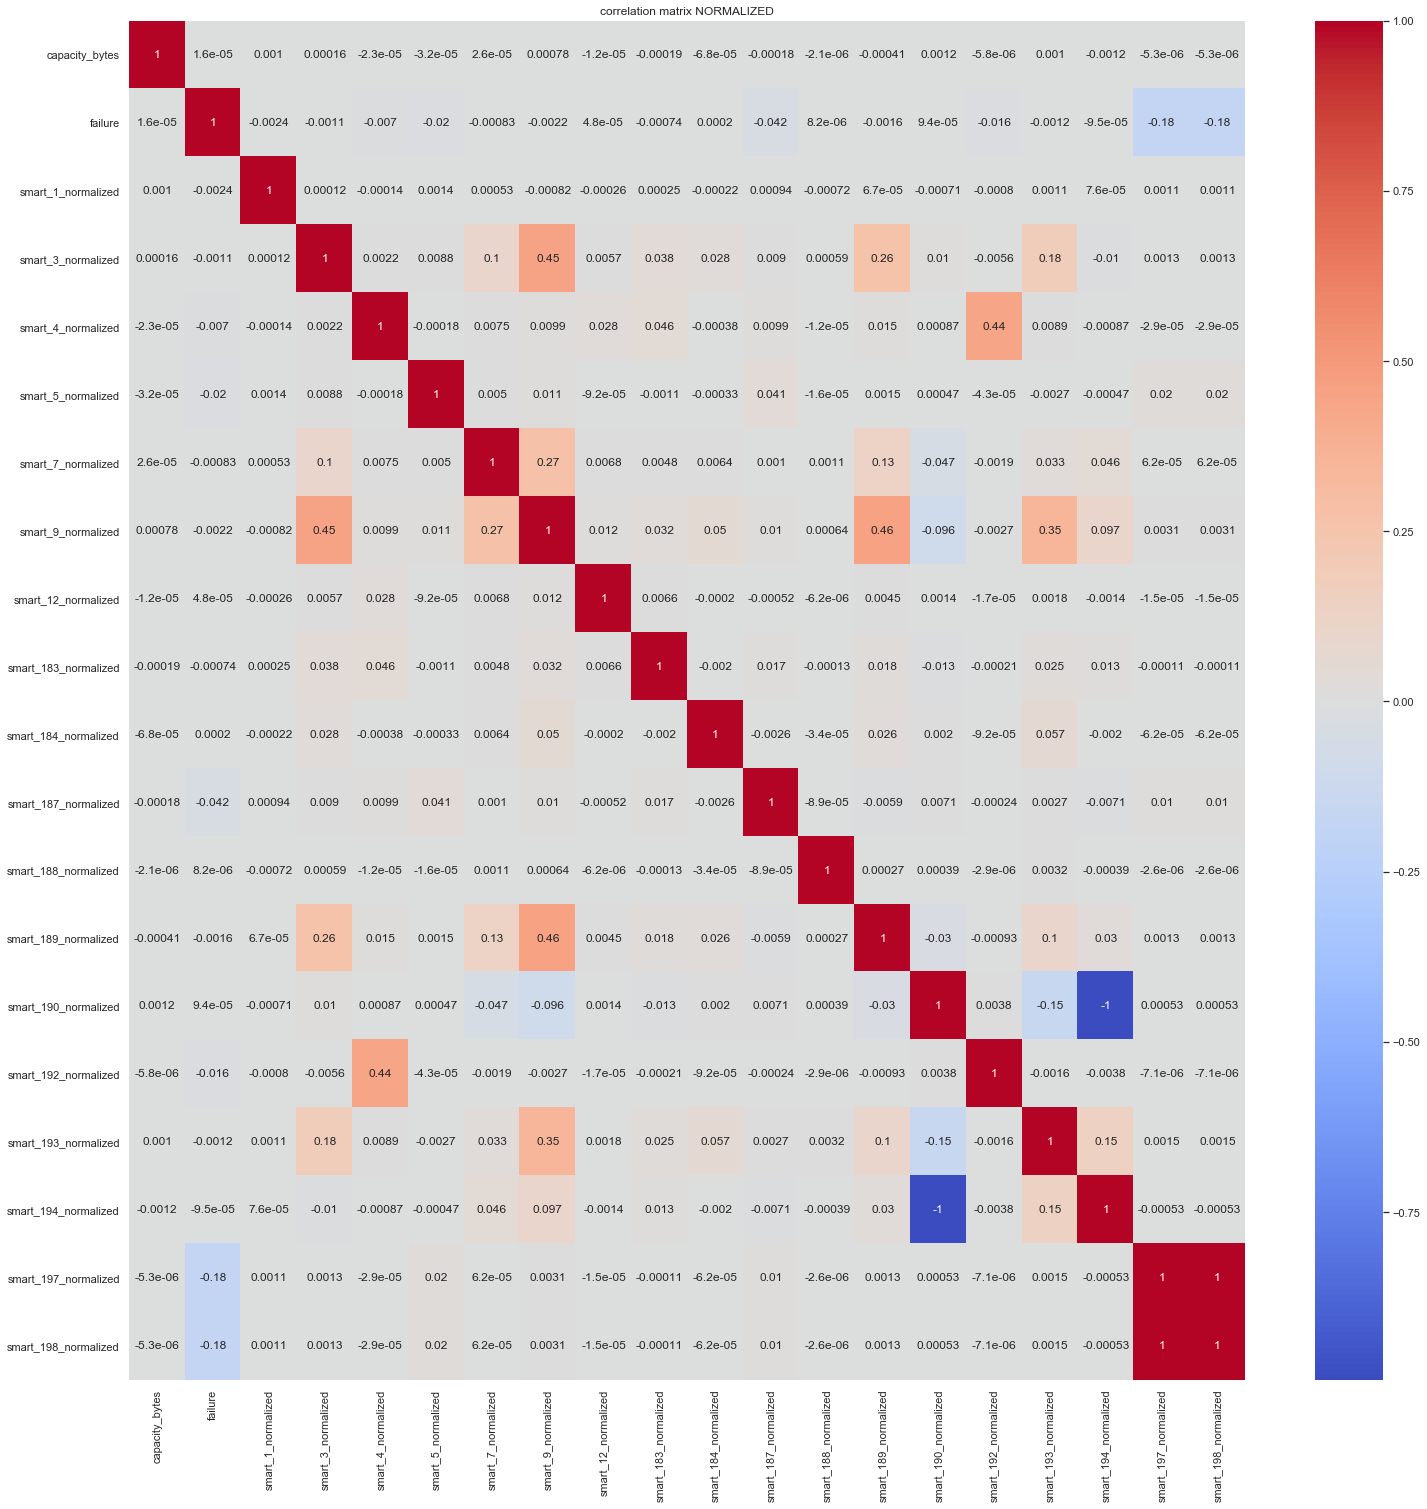

In [40]:
# NORMALIZED
hd_corr_norm = df_norm.corr()

plt.figure(figsize=(25,25))

# draw the heatmap using seaborn.
sns.heatmap(hd_corr_norm, annot=True, cmap= 'coolwarm')
plt.title("correlation matrix NORMALIZED")

plt.show()

An observation:
- `smart_194_normalized` (Temperature) and `smart_190_normalized` (Temperature Difference) are negatively correlated at -1.00.  Makes sense that they are related, so I will drop the latter.

In [41]:
to_drop_norm = ['smart_190_normalized']
df_norm.drop(columns=to_drop_norm, axis=1, inplace=True)
df_ints.drop(columns=to_drop_norm, axis=1, inplace=True)

#### Scatter Plot Matrix

##### RAW

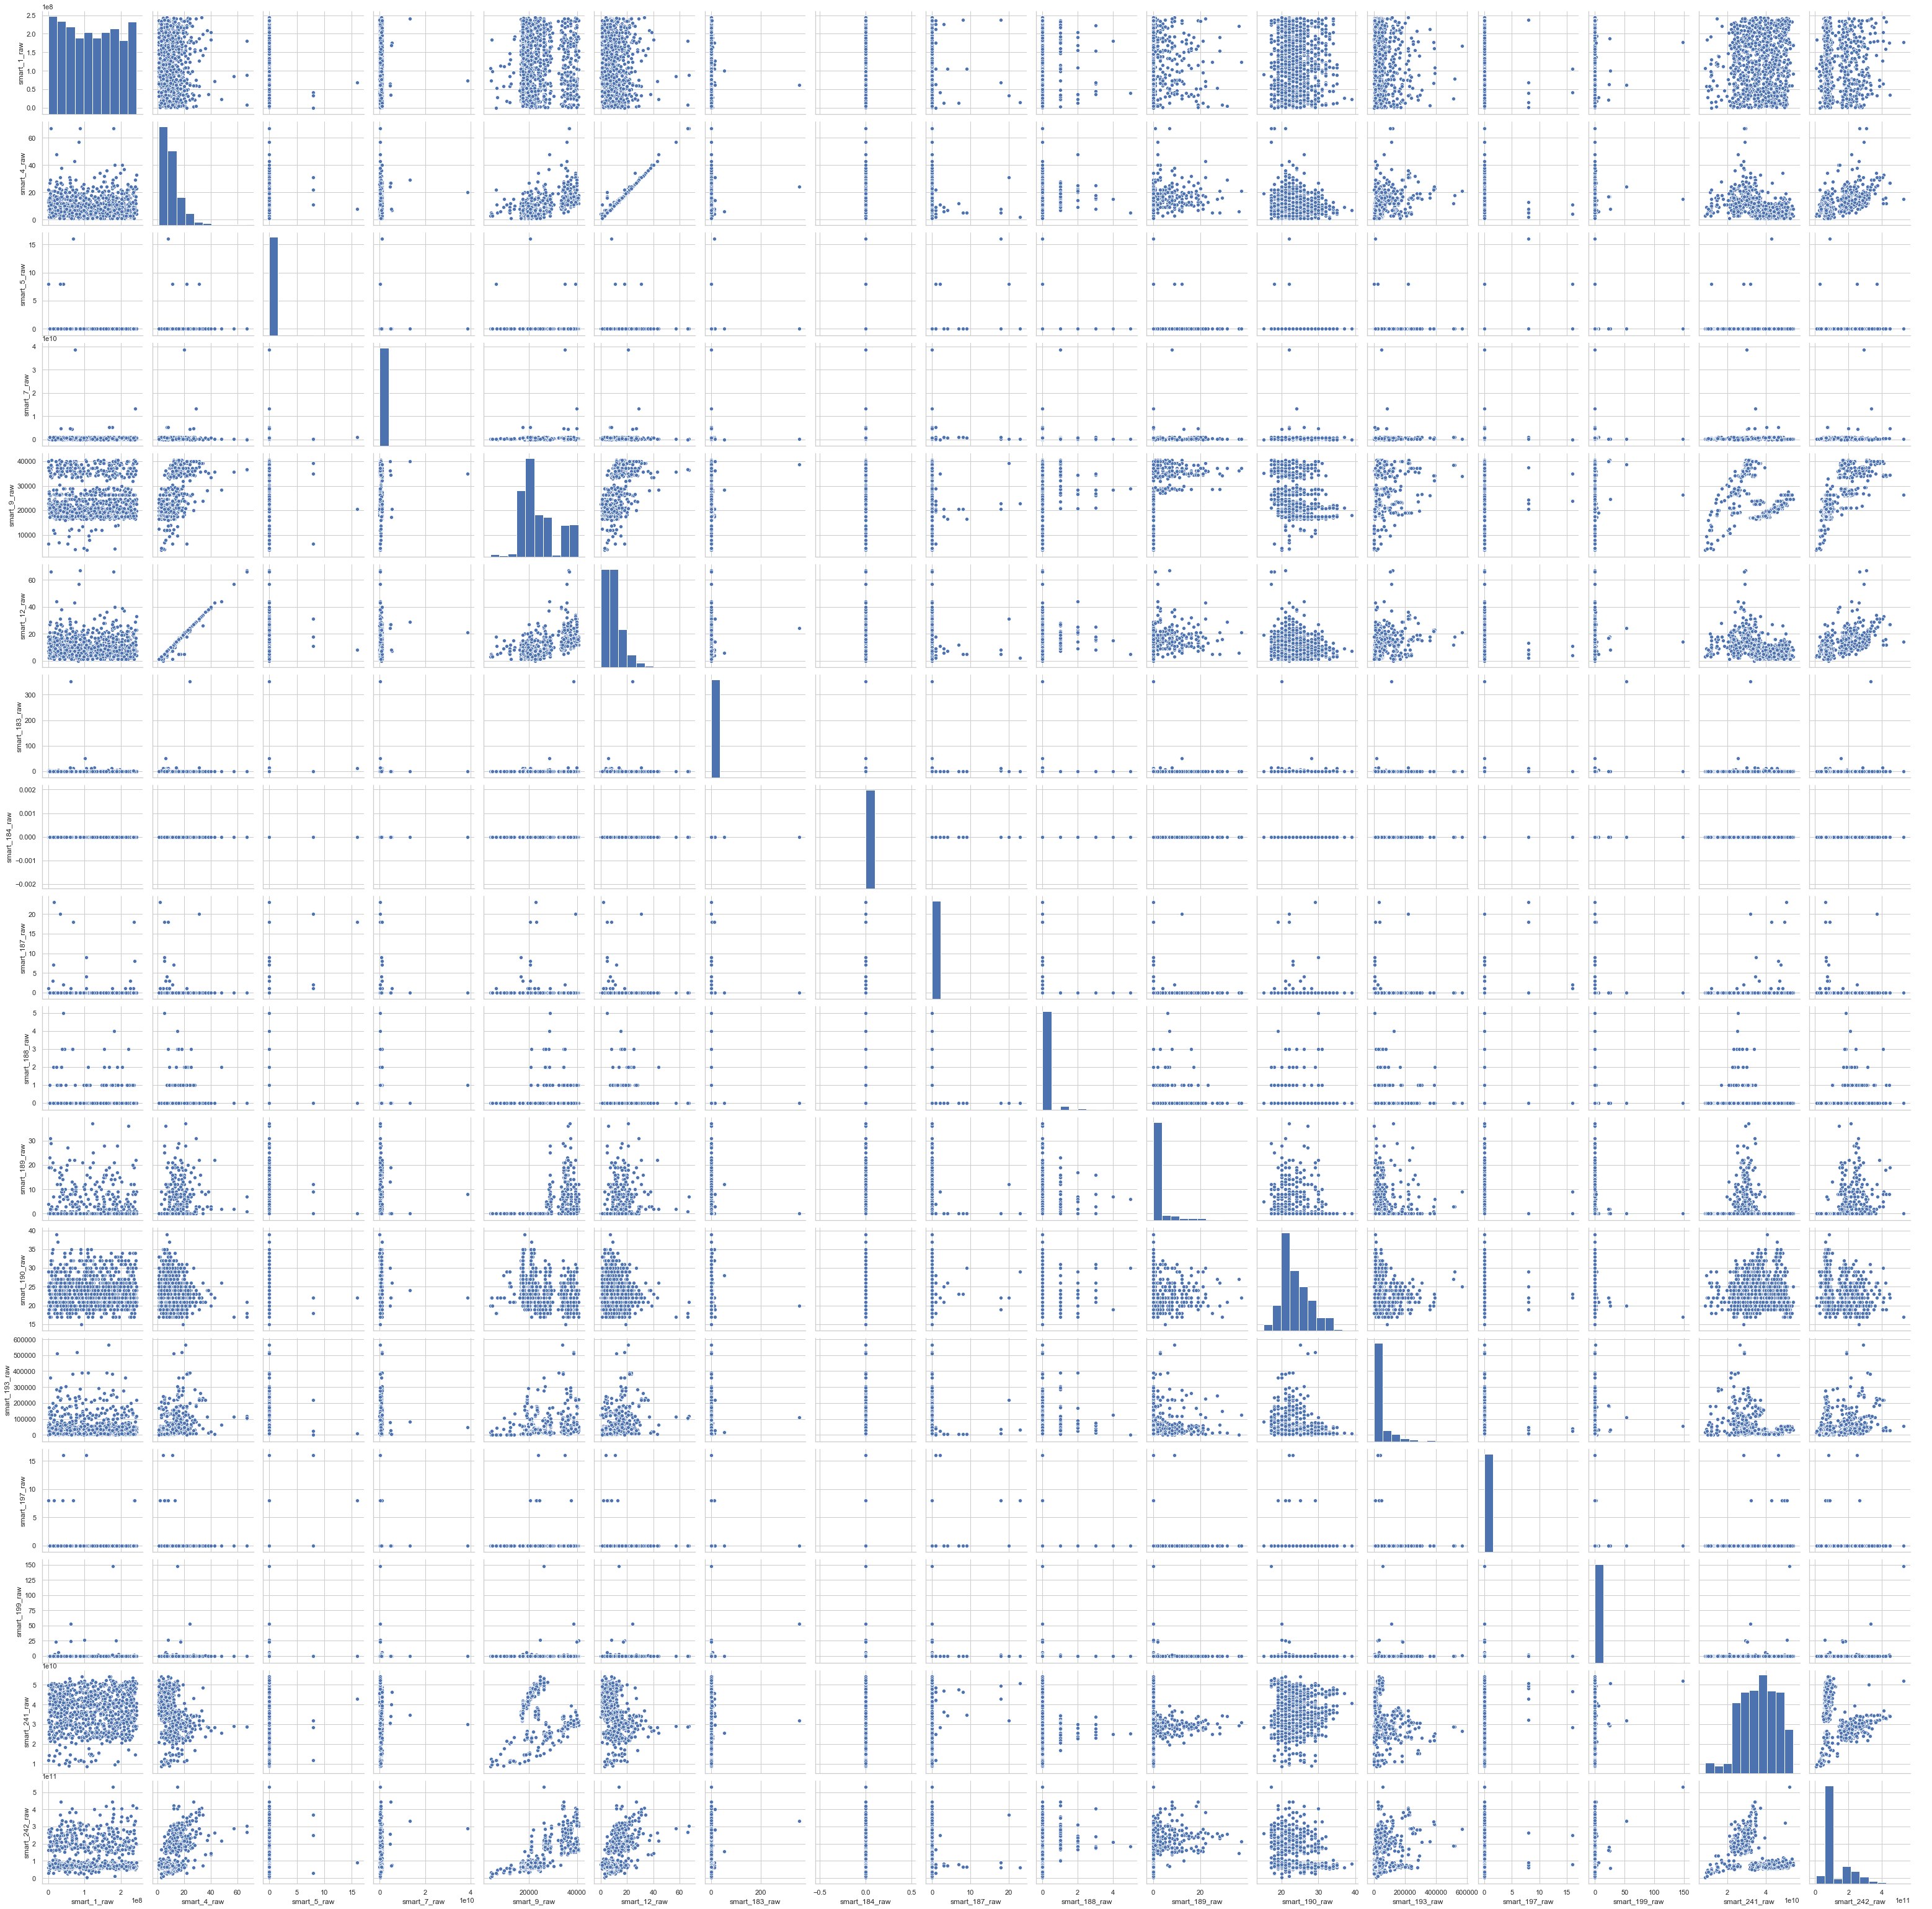

In [42]:
# Only running 1000 rows for speed, when I have more time, should do whole df
sns.pairplot(df_raw.iloc[:1000,5:])

##### NORMALIZED

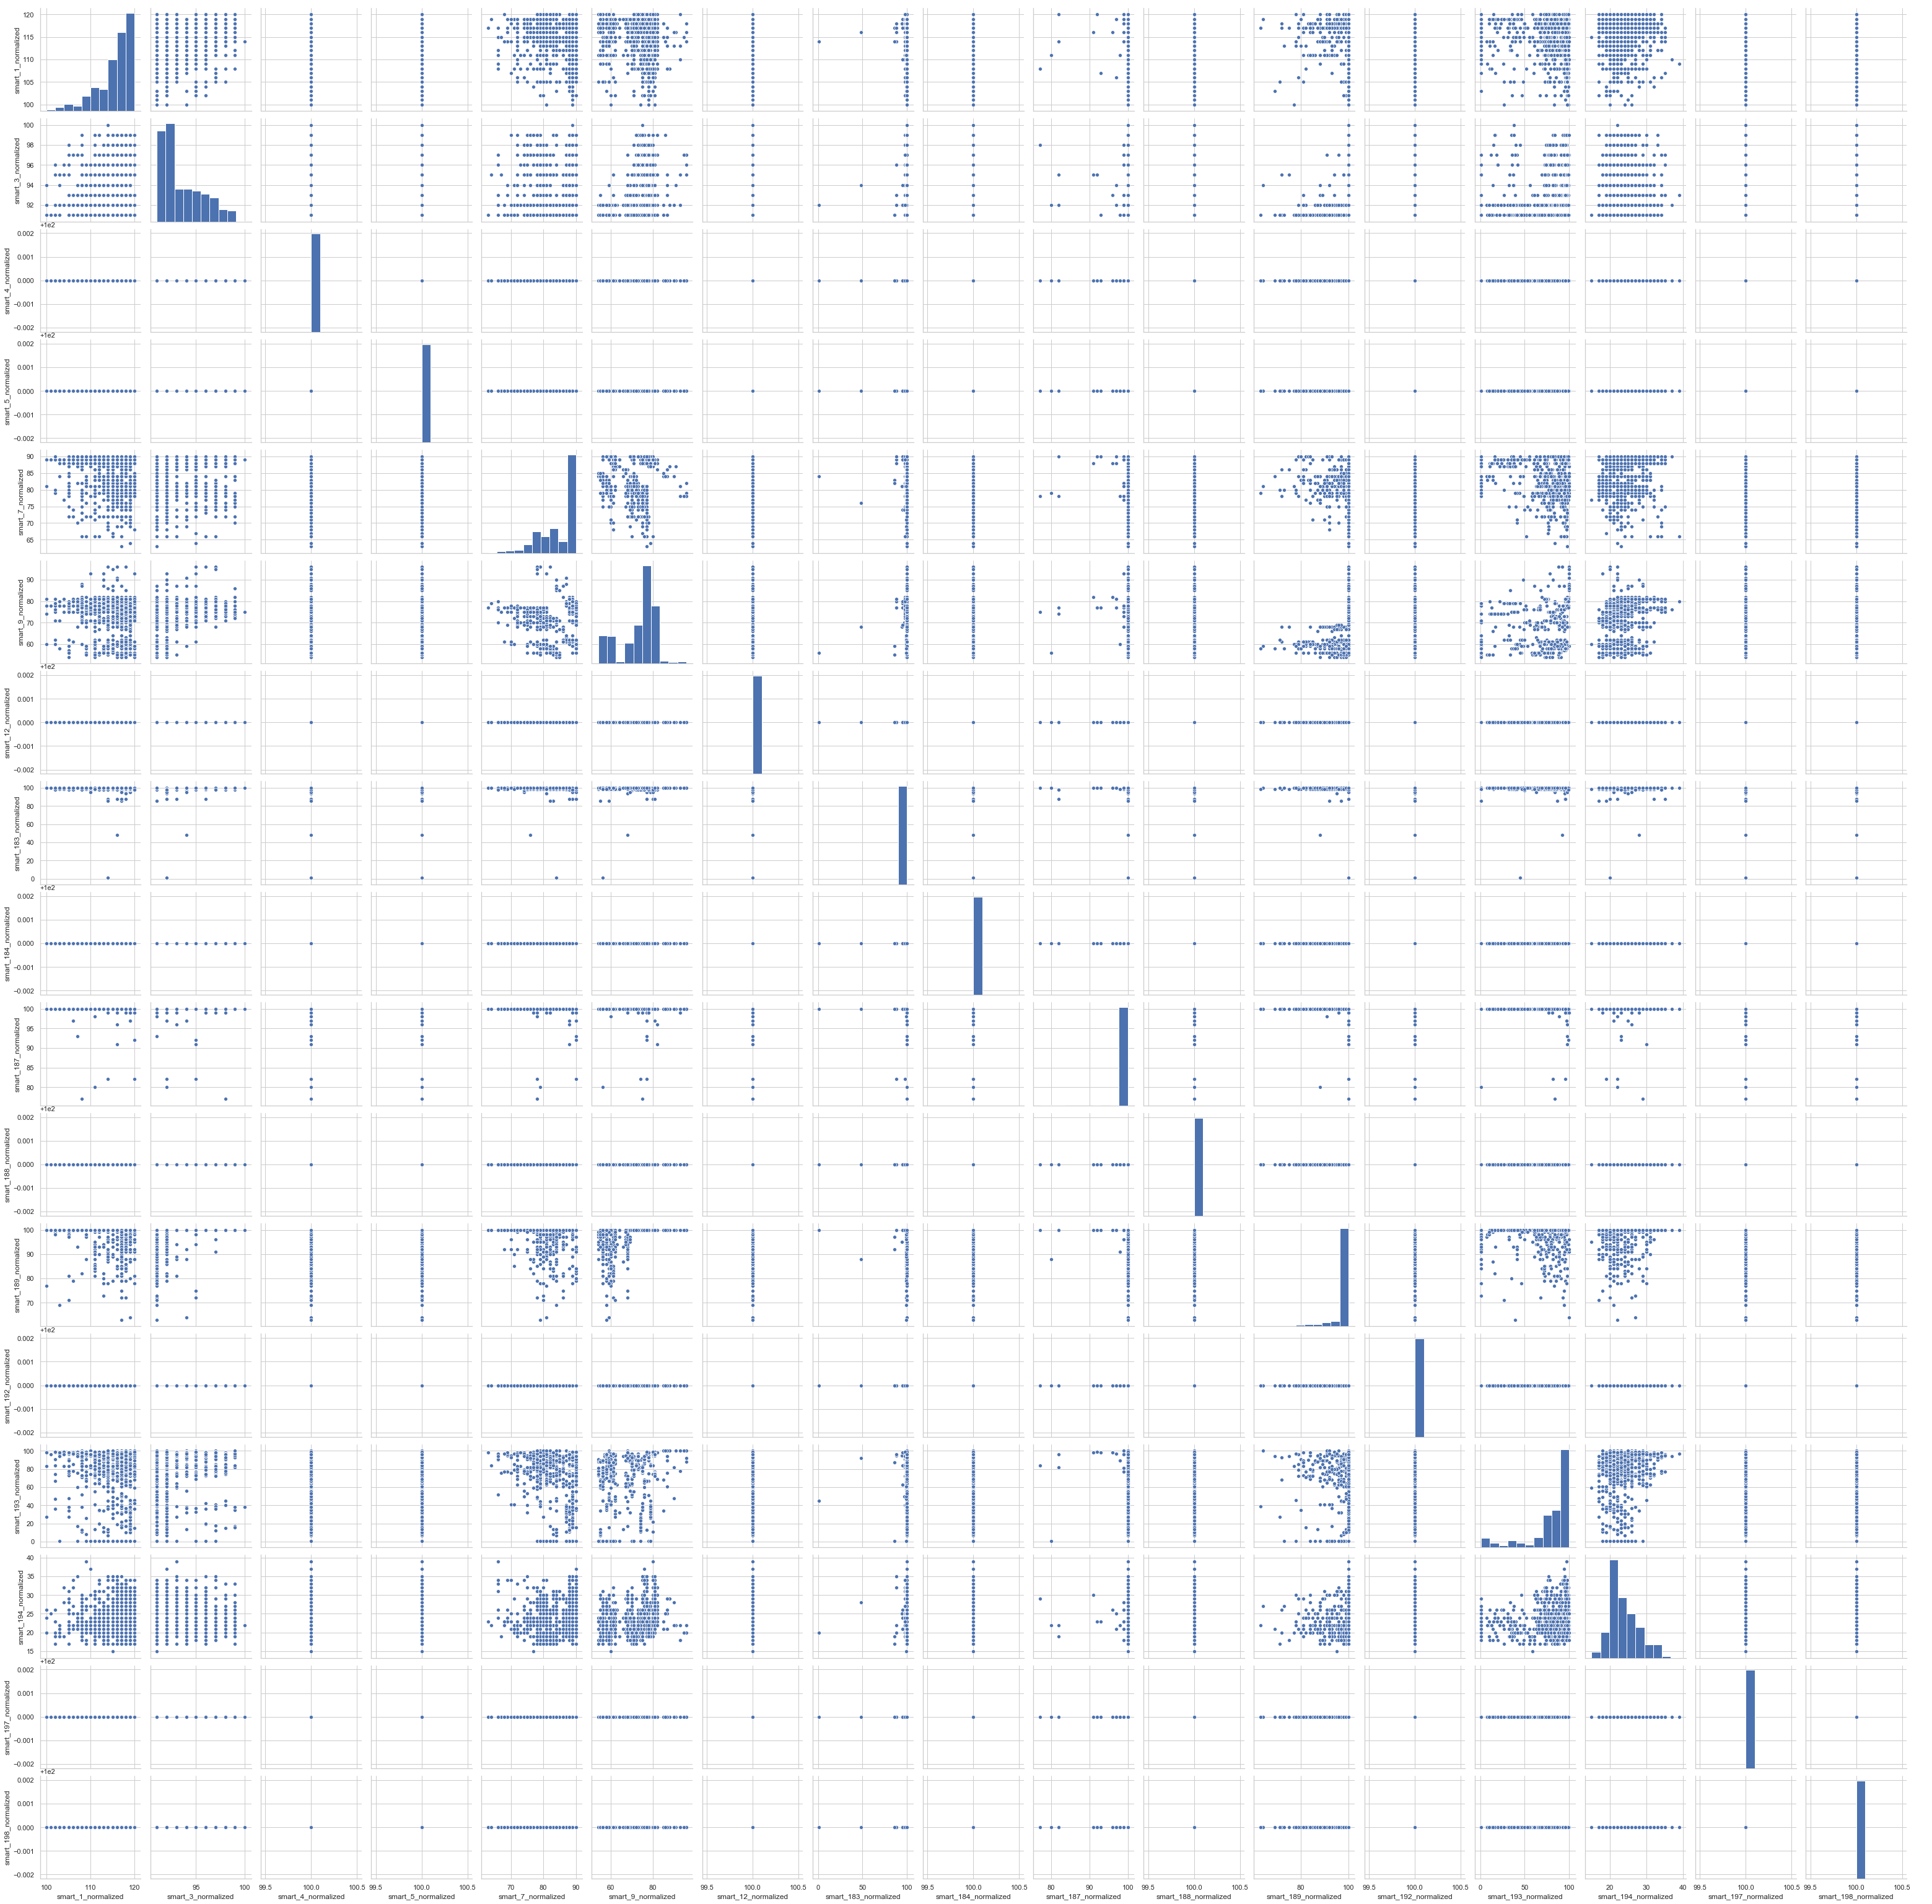

In [43]:
# Only running 1000 rows for speed, when I have more time, should do whole df
sns.pairplot(df_norm.iloc[:1000,5:])

Overall, nothing really stands out.  There are some correlations that look too perfect (eg normalized SMART 190 and 194).  A bunch of them are really stagnant and not really interesting.

#### Bivariate Analysis

In [44]:
show_max_columns(df_ints.groupby("failure").mean())

,capacity_bytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_189_normalized,smart_189_raw,smart_190_raw,smart_191_normalized,smart_191_raw,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
failure,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.000770e+12,115.295849,1.220491e+08,93.342499,0.0,99.999857,10.398828,99.995940,5.225562,84.072280,1.117935e+10,72.454534,24568.366123,100.0,0.0,99.999458,10.501086,99.312739,3.205235,99.977454,0.022546,99.880626,0.119374,99.999999,0.129218,97.955443,4.716437,23.838717,100.0,0.0,99.999993,78.546358,47968.220035,23.838717,99.999920,0.179361,99.999920,200.0,2.215409,100.0,100.0,3.595540e+10,100.0,1.229488e+11
1,4.000787e+12,114.134831,1.194468e+08,93.022472,0.0,99.988764,27.320225,99.325843,867.056180,83.460674,9.245988e+08,70.000000,26733.179775,100.0,0.0,100.000000,12.000000,98.792135,1.207865,99.994382,0.005618,92.601124,24.651685,100.000000,0.297753,96.730337,3.269663,23.792135,100.0,0.0,99.994382,74.640449,54906.376404,23.792135,98.438202,294.786517,98.438202,200.0,0.179775,100.0,100.0,3.178055e+10,100.0,1.586886e+11


Most things are similar.  The main difference between a failed and non-failed drive:
 - `smart_4_raw`
 - `smart_5_raw`
 - `smart_187_raw`
 - `smart_197_raw`

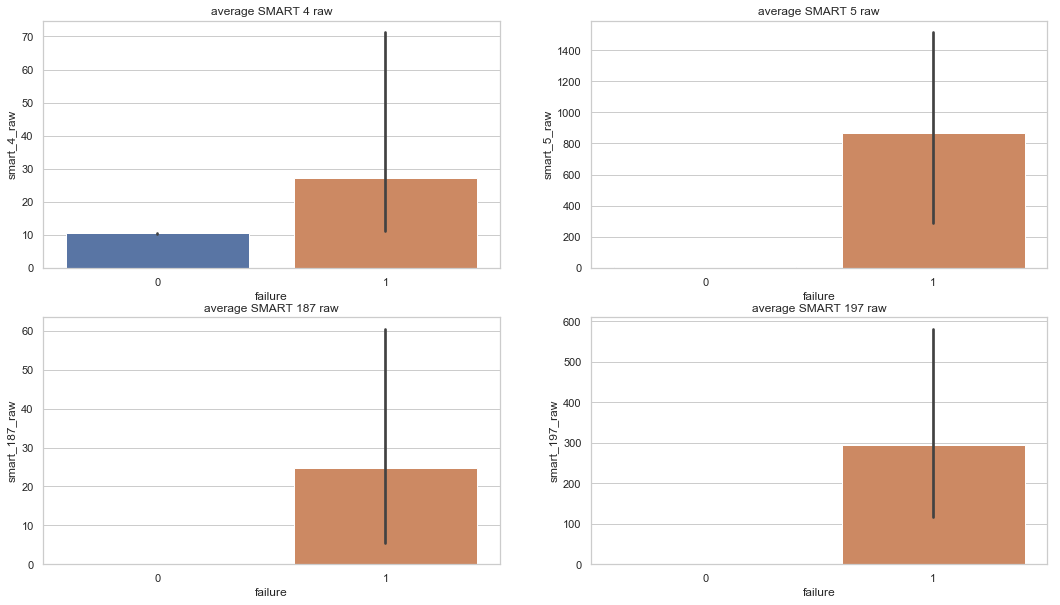

In [45]:
#WARNING takes 10 minutes to run
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.barplot(df_ints.failure, df_ints.smart_4_raw)
plt.title('average SMART 4 raw')

plt.subplot(2,2,2)
sns.barplot(df_ints.failure, df_ints.smart_5_raw)
plt.title('average SMART 5 raw')

plt.subplot(2,2,3)
sns.barplot(df_ints.failure, df_ints.smart_187_raw)
plt.title('average SMART 187 raw')

plt.subplot(2,2,4)
sns.barplot(df_ints.failure, df_ints.smart_197_raw)
plt.title('average SMART 197 raw')

plt.show()

In [46]:
# Test whether group differences are significant.
import scipy.stats as stats

failure = df_ints["failure"].unique()
grouped_df = df_ints.groupby("failure")
for var in ["smart_4_raw", "smart_5_raw", "smart_187_raw", "smart_197_raw"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(failure)):
        for j in range(i+1, len(failure)):
            print("t-test between groups {0} and {1}:".format(failure[i], failure[j]))
            print(stats.ttest_ind(
                df_ints[df_ints["failure"]==failure[i]][var], 
                df_ints[df_ints["failure"]==failure[j]][var]
            ))

------------------------------------------------
Comparisons for variable: smart_4_raw
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-11.528427918298497, pvalue=9.50108350684414e-31)
------------------------------------------------
Comparisons for variable: smart_5_raw
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-33.04836930278762, pvalue=1.825103394869627e-239)
------------------------------------------------
Comparisons for variable: smart_187_raw
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-157.4480674314549, pvalue=0.0)
------------------------------------------------
Comparisons for variable: smart_197_raw
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-306.34298059601315, pvalue=0.0)


All p-values are smaller than 0.05, so they are all significantly different.

## Feature Engineering

In [49]:
df_ints.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2018-02-04,Z305B2QN,ST4000DM000,4000787030016,0,118,179547432,91,0,100,...,100,0,100,200,0,100,100,39861309504,100,61223935581
5,2018-02-04,Z305DEMG,ST4000DM000,4000787030016,0,114,77562744,97,0,100,...,100,0,100,200,0,100,100,33761503720,100,67591424864
10,2018-02-04,Z3023VGH,ST4000DM000,4000787030016,0,112,45302624,92,0,100,...,100,0,100,200,0,100,100,23172730201,100,171042731260
13,2018-02-04,Z305DEMX,ST4000DM000,4000787030016,0,112,48269528,93,0,100,...,100,0,100,200,0,100,100,40319606344,100,60960743336
19,2018-02-04,Z306WYZZ,ST4000DM000,4000787030016,0,114,73815424,95,0,100,...,100,0,100,200,0,100,100,12566112872,100,33641419848


In [53]:
# LastDayWorking_DataFrame
# Only keeping last day recorded of each hard drive
ldw_df = df_ints.sort_values('date').groupby('serial_number').nth(-1)

In [54]:
ldw_df.shape

(32091, 47)

Dropping `date` column as that would be a dead giveaway, as drives still operable at 03/31/2018 are clearly not failed.  Also dropping `serial_number` as every row is a seperate hd.

In [56]:
ldw_df.reset_index().drop(columns=['serial_number', 'date'], inplace=True)
cols_to_keep = [col for col in ldw_df.columns if 'smart' in col]

features = ldw_df[cols_to_keep]
labels = ldw_df['failure']

## Dimensionality Reduction

### PCA

In [62]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [63]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,6))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='red')

    fig.tight_layout()  
    plt.show()

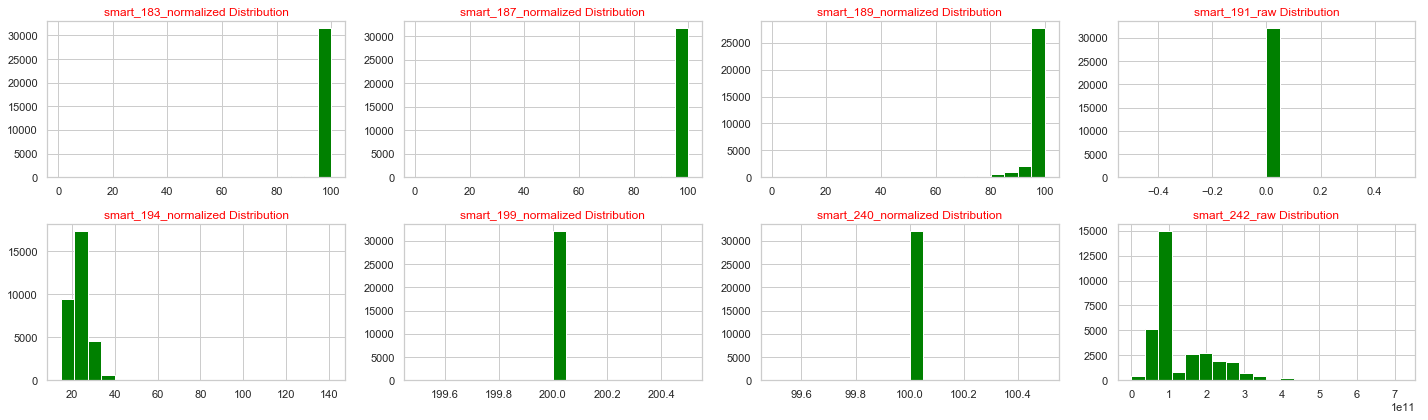

In [63]:
# Sample histograms
histograms_plot(features,features.columns[[4,8,12,16,20,24,28,32]],2,4)

#### Transforming/Scaling the Data

In [64]:
transformer = RobustScaler().fit(features)
X_transformed = transformer.transform(features)

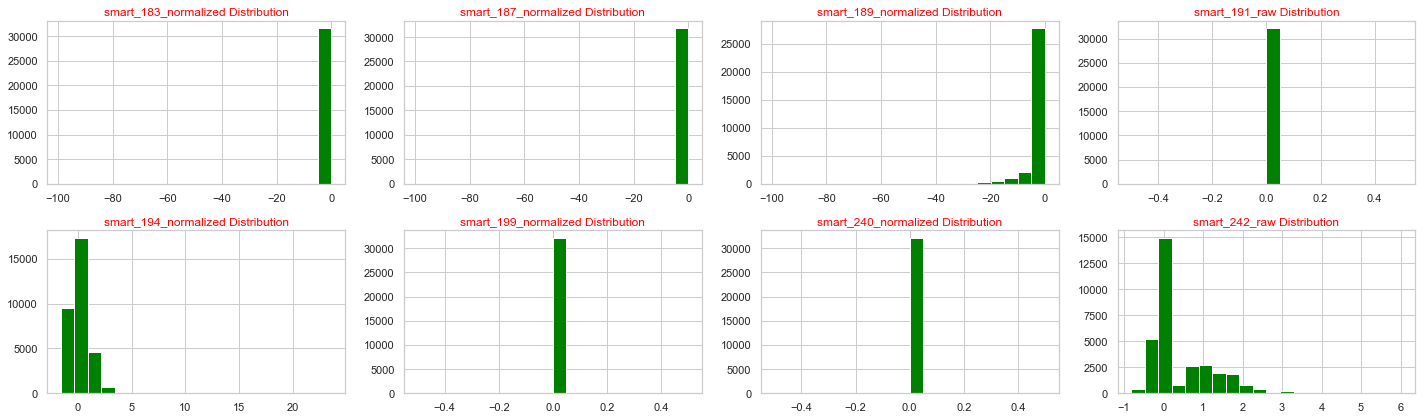

In [65]:
X_transformed_df = pd.DataFrame(data=X_transformed, columns=features.columns.tolist())
# Sample histograms
histograms_plot(X_transformed_df,X_transformed_df.columns[[4,8,12,16,20,24,28,32]],2,4)

All it did was shift the histogram where the mean is 0 and each unit is a standard deviation.

In [66]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_transformed)

In [67]:
X_reduced

array([[-14.23253457,  -9.26014858],
       [-14.38019227,  -9.26020577],
       [-14.17812615,  -9.25998203],
       ...,
       [-14.26351933,  -9.2605652 ],
       [-14.40143508,  -9.26052298],
       [-14.48314214,  -9.26051839]])

Is 2 dimensions all that's needed?

In [68]:
X_reduced_df = pd.DataFrame(data=X_reduced)
X_reduced_df.shape

(32091, 2)

In [69]:
pca = PCA()
pca.fit(features)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

1

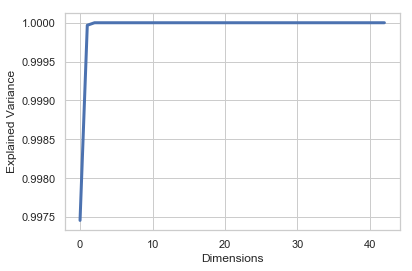

In [70]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

The cumulative *explained variance ratio* as a function of the number of components shows over 95% of variance is preserved with only 2 dimensions/components.  Most likely due to the massive class imbalance.  I will not be pursueing PCA if that is the case.

## Running Models

Something to note is the huge class imbalance (so many non-fails compared to fails).

A gradient-boosting model is most appropriate for this type of data, so we can run a weighted model to make sure failures are weighted properly.

In [72]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=123,
                                                    stratify=labels)

In [75]:
X_train.shape

(25672, 43)

In [76]:
X_train.describe()

,smart_10_normalized,smart_10_raw,smart_12_normalized,smart_12_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,...,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw
count,25672.0,25672.0,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000,...,25672.000000,25672.0,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000,25672.000000
mean,0.0,0.0,-0.000623,0.364132,-0.734614,3.619235,-0.026839,0.026839,-0.180196,0.299821,...,0.315100,0.0,-0.000195,0.309871,-0.008219,10.495715,-0.043294,0.630641,-0.257415,0.235835
std,0.0,0.0,0.099860,12.903701,5.803506,245.799618,0.752038,0.752038,2.123054,16.449236,...,0.571399,0.0,0.016512,2.733871,0.355772,462.907065,0.621231,20.240313,0.791807,0.796328
min,0.0,0.0,-16.000000,-1.000000,-99.000000,0.000000,-72.000000,0.000000,-99.000000,0.000000,...,-0.250000,0.0,-2.000000,-0.777778,-33.000000,0.000000,-2.888889,-0.360641,-2.000000,-2.375540
25%,0.0,0.0,0.000000,-0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,0.0,0.000000,-0.333333,0.000000,0.000000,-0.444444,-0.215751,-0.727273,-0.315379
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002918,0.000000,-0.000104
75%,0.0,0.0,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.750000,0.0,0.000000,0.666667,0.000000,0.000000,0.555556,0.784899,0.272727,0.684673
max,0.0,0.0,0.000000,2052.125000,0.000000,37728.000000,0.000000,72.000000,0.000000,2526.000000,...,2.000000,0.0,0.000000,298.000000,0.000000,43608.000000,1.777778,2695.218400,2.363636,1.941088


In [113]:
print('X_train rows: ', len(X_train))

print('X_test rows: ', len(X_test))

print('y_train failures: ', y_train.sum())

print('y_test failures: ', y_test.sum())

print('Train target ratio: ', y_train.sum()/len(y_train))

print('Test target ratio: ', y_test.sum()/len(y_test))

X_train rows:  25672
X_test rows:  6419
y_train failures:  141
y_test failures:  35
Train target ratio:  0.005492365222810844
Test target ratio:  0.0054525627044711015


## Naive Bayes
---

In [78]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_pred = bnb.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X_test.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 6419 points : 60


In [79]:
from sklearn import metrics

def get_metrics(preds, labels):
    acc = metrics.accuracy_score(labels, preds)
    recall = metrics.recall_score(labels, preds)
    precision = metrics.precision_score(labels, preds)
    F1 = metrics.f1_score(labels, preds)
    auc = metrics.roc_auc_score(labels, preds)
    confusion_matrix = metrics.confusion_matrix(labels, preds, labels=(0, 1))
    
    print('Accuracy: ', acc)
    print('Recall: ', recall)
    print('Precision: ', precision)
    print('F1: ', F1)
    print('Area Under Curve: ', auc)
    print(confusion_matrix)
#     return [acc, recall, precision, F1, auc] + list(confusion_matrix.ravel())

In [80]:
get_metrics(y_pred, y_test)

Accuracy:  0.9906527496494781
Recall:  0.34285714285714286
Precision:  0.24489795918367346
F1:  0.28571428571428575
Area Under Curve:  0.668530701754386
[[6347   37]
 [  23   12]]


False Negative: 23 out of 35

False Positive: 37 out of 49

`Recall`: How many actual `1`'s were predicted to be `1`: 34%

`Precision`: Of all HD predicted `1`, how many were actually `1`: 24%

Although the model is 99% accurate, it's missing too many failed drives based on AUC: 66%.

I will go with AUC as the defining metric, as in a preventative maintenance scenerio, we'll want to avoid too many false positives, unnecessairly replacing too many HDDs, but we also don't want to miss too many unexpected HDD failures, as that'll cause more downtime, so we want to minimize both.

### Cross Value
#### Training

In [87]:
from sklearn.model_selection import cross_val_score
def cv_scores(model, features, label, cv=10, scoring='roc_auc'):
    scores = cross_val_score(model, features, label, cv=10, scoring='roc_auc')
    print(scores)
    print('Average: ', sum(scores)/len(scores))
    
cv_scores(bnb, X_train, y_train, cv=10, scoring='roc_auc')

[0.91306354 0.81073247 0.81871468 0.85991271 0.81303508 0.89544513
 0.76334564 0.85336579 0.66838733 0.81125846]
Average:  0.8207260844676153


#### Test

In [88]:
cv_scores(bnb, X_test, y_test, cv=5, scoring='roc_auc')

[0.69692227 0.795253   0.81168492 0.94131455 0.81759404 0.73667712
 0.95023511 0.77860502 0.62147335 0.79231975]
Average:  0.7942079140931739


There's slight overfitting to keep an eye on.

## KNN
---

In [93]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = KNeighborsClassifier()
neighbors.fit(X_train, y_train)

y_pred = neighbors.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X_test.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 6419 points : 34


In [94]:
get_metrics(y_pred, y_test)

Accuracy:  0.994703224801371
Recall:  0.11428571428571428
Precision:  0.5714285714285714
F1:  0.19047619047619044
Area Under Curve:  0.5569078947368421
[[6381    3]
 [  31    4]]


Recall is abysimal (only accurately finding 4 out of 35)

### Cross Value

#### Train

In [95]:
cv_scores(neighbors, X_train, y_train, cv=10, scoring='roc_auc')

[0.74548328 0.69409845 0.67258407 0.60165911 0.67291981 0.70936154
 0.67546584 0.63712159 0.56502154 0.74328521]
Average:  0.6717000444877431


#### Test

In [96]:
cv_scores(neighbors, X_test, y_test, cv=5, scoring='roc_auc')

[0.82420449 0.65545123 0.82968179 0.4913928  0.61500784 0.61559561
 0.74235893 0.49373041 0.49529781 0.66039707]
Average:  0.6423117977574024


Slight overfitting, but scores are worse than Naive Bayes

## Random Forest
---

In [97]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X_test.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 6419 points : 33


In [98]:
get_metrics(y_pred, y_test)

Accuracy:  0.994859012307213
Recall:  0.08571428571428572
Precision:  0.75
F1:  0.15384615384615383
Area Under Curve:  0.5427788220551377
[[6383    1]
 [  32    3]]


### Cross Value

#### Train

In [99]:
cv_scores(rfc, X_train, y_train, cv=10, scoring='roc_auc')

[0.94090502 0.899308   0.9818281  0.95124783 0.93913323 0.8572128
 0.82580717 0.86514465 0.8671451  0.93562196]
Average:  0.9063353869295104


#### Test

In [100]:
cv_scores(rfc, X_test, y_test, cv=5, scoring='roc_auc')

[0.80699009 0.80672926 0.80672926 0.97600417 0.84952978 0.82660658
 0.99020376 0.82092476 0.55094044 0.62173459]
Average:  0.8056392707224422


Although the scores are looking much better than the other models, we do see some serious overfitting (90% training 80% test) so I'll have to tweak settings more if I am to use this model.

## Support Vector
---

In [102]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X_test.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 6419 points : 35


In [103]:
get_metrics(y_pred, y_test)

Accuracy:  0.9945474372955289
Recall:  0.02857142857142857
Precision:  0.5
F1:  0.05405405405405405
Area Under Curve:  0.5142073934837091
[[6383    1]
 [  34    1]]


### Cross Value

#### Train

In [104]:
cv_scores(svc, X_train, y_train, cv=10, scoring='roc_auc')

[0.62473431 0.76030813 0.77404734 0.80423591 0.6569582  0.63902412
 0.74503385 0.58457837 0.69724694 0.67128308]
Average:  0.6957450256084964


#### Test

In [105]:
cv_scores(svc, X_test, y_test, cv=5, scoring='roc_auc')

[0.8695879  0.55659885 0.52425665 0.75691184 0.62225705 0.69318182
 0.40830721 0.70924765 0.32170846 0.58254963]
Average:  0.604460707119765


Although there's overfitting (69% Train 60% Test) the AUC scores are nothing to write home about.

## Gradient Boosting
---

In [108]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# predict_train = clf.predict(X_train)
# predict_test = clf.predict(X_test)

y_pred = clf.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X_test.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 6419 points : 39


In [109]:
get_metrics(y_pred, y_test)

Accuracy:  0.9939242872721608
Recall:  0.34285714285714286
Precision:  0.42857142857142855
F1:  0.38095238095238093
Area Under Curve:  0.6701754385964913
[[6368   16]
 [  23   12]]


### Cross Value

#### Train

In [110]:
cv_scores(clf, X_train, y_train, cv=10, scoring='roc_auc')

[0.88462076 0.79541716 0.55715964 0.89519333 0.91551956 0.8069638
 0.81145431 0.67168877 0.77082984 0.90873482]
Average:  0.8017581985040534


#### Test

In [111]:
cv_scores(clf, X_test, y_test, cv=5, scoring='roc_auc')

[0.7209181  0.74543558 0.95852895 0.72248305 0.9161442  0.71512539
 0.71590909 0.68103448 0.71845611 0.12173459]
Average:  0.7015769541783382


There's overfitting (80% Train 70% Test) with the AUC scores.  The scores are decent too and shows promise if modified.

## Next Steps

---

If I had more time, here are the things I would do:
#### Start with a larger dataset
    Although the dataset was quite large, after filtering by hard drive model and splitting training and test set, considering the huge class imbalance, it left us with a tiny amount of failed hard-drives.  I would expect to get more consistent results if we concact multiple quarters/years of data together.
#### Do something about the class imbalance
    After filtering for hard-drive of interest, we were starting with only 176 failed drives.  With ~175/quarter and data being collected since 2013: 6 years, 4 quarters each, that's roughly 24*175 ~= 4200 failed drives from 2013-2019.  It makes sense to try undersampling with that size of data.
    
    I could also try SMOTE to synthetically oversample the failed drives, although it isn't the most effective with high-dimensional data like we have here.
#### Try predicting even earlier
    Is it really predicting if it is the day of?  We should try predicting the day before, a week or even a month earlier.
#### Optimizing models
    After figuring out which model shows the most potential, with more time, I should optimize the model.  Would also help to have a larger dataset in general.
#### Create pipeline
    As data continues to come in, if this model is to go into production, I should export the trained models and create a pipeline for the new data to be implemented.
#### Repeat with different hard-drive models
    We only looked at one particular hard drive model.  Once we have a pipe-line set, it would make sense to run different models through the pipe-line to see if we get differing results.